# IT service tickets binary classification using data mining techniques.

In this document , I have evaluated the perfromance of 3-diiferent classification algorthms in classifying the IT service tickets.

These are the algorthms I have choosen :

1. Random Forest
2. SVM - Support Vector Machine
3. LSTM - Long Short Term Memory

The dataset used for task is taken from Kaggle ,https://www.kaggle.com/datasets/adisongoh/it-service-ticket-classification-dataset

# Importing Libraries


In [2]:
#installing libraries
! pip install pandas scikit-learn tensorflow matplotlib nltk keras


In [3]:
#Libraries
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#Reading the dataset

In [4]:
df = pd.read_csv("all_tickets_processed_improved_v3.csv")
df.head()

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [5]:
print(f"Total number of records in the data : {df.shape[0]}")

Total number of records in the data : 47837


In [6]:
print("Number of classes in the dataset and their distribution")
df['Topic_group'].value_counts()

Number of classes in the dataset and their distribution


Topic_group
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760
Name: count, dtype: int64

The dataset has total of 8 categories of data, since the idea is to perfrom binary classification. I have choosen 2000 records from **Internal Project** category and 2000 records from **Purchase** categroy. Together making a dataset of size 4000 records

In [7]:
#filter the data
data = df[df['Topic_group'].isin(['Internal Project','Purchase'])]
data.shape

(4583, 2)

In [8]:
# Select 1000 records from each class
purchase_records = data[data['Topic_group'] == 'Purchase'].head(2000)
internal_project_records = data[data['Topic_group'] == 'Internal Project'].head(2000)
# Concatenate the selected records to create a new DataFrame with 4000 records
df = pd.concat([purchase_records, internal_project_records])

# Reset the index of the new DataFrame
df.reset_index(drop=True, inplace=True)

In [9]:
df.shape

(4000, 2)

<Axes: title={'center': 'Data distribution between two classes'}, xlabel='Topic_group'>

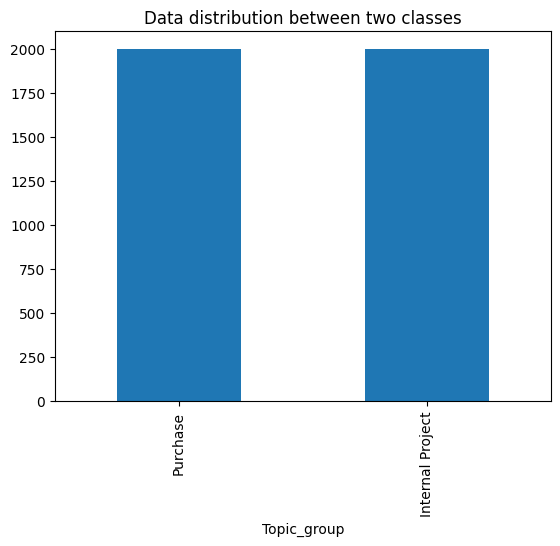

In [10]:
df['Topic_group'].value_counts().plot(kind = 'bar', title = "Data distribution between two classes" )

In [11]:
df.head()

,Document,Topic_group
0,system hello movement has left available devic...,Purchase
1,list sent copy copy hi receive copy behavior e...,Purchase
2,new purchase po purchase po dear purchased rec...,Purchase
3,system re hello please make injector device de...,Purchase
4,new purchase po purchase po dear purchased has...,Purchase


## Text cleaning

In the text cleaning step:<br>
 1. converted the text to lowercases
 2.  removed digits and numbers
 3. Removed punctuations
 4. Tokenized the text using word tokenizer
 5. Removed stopword if any

In [12]:
#cleaning the text
# Text cleaning function
stopwords_eng  = stopwords.words('english')
def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([word for word in word_tokenize(text) if word not in stopwords_eng ])  # Remove stopwords
    return text

In [13]:
df['Cleaned_Document'] = df['Document'].apply(clean_text)

In [14]:
df.head()

,Document,Topic_group,Cleaned_Document
0,system hello movement has left available devic...,Purchase,system hello movement left available device pl...
1,list sent copy copy hi receive copy behavior e...,Purchase,list sent copy copy hi receive copy behavior e...
2,new purchase po purchase po dear purchased rec...,Purchase,new purchase po purchase po dear purchased rec...
3,system re hello please make injector device de...,Purchase,system hello please make injector device devic...
4,new purchase po purchase po dear purchased has...,Purchase,new purchase po purchase po dear purchased ple...


In [15]:
df['label'] = df['Topic_group'].map({'Purchase':0,"Internal Project":1})
df.head()

,Document,Topic_group,Cleaned_Document,label
0,system hello movement has left available devic...,Purchase,system hello movement left available device pl...,0
1,list sent copy copy hi receive copy behavior e...,Purchase,list sent copy copy hi receive copy behavior e...,0
2,new purchase po purchase po dear purchased rec...,Purchase,new purchase po purchase po dear purchased rec...,0
3,system re hello please make injector device de...,Purchase,system hello please make injector device devic...,0
4,new purchase po purchase po dear purchased has...,Purchase,new purchase po purchase po dear purchased ple...,0


## Text vectorization
**TF-IDF** stands ( Term Frequency-Inverse Document Frequency). Is a statistical measure in natural language processing and information retrieval to evaluate the importance of a word in a document relative to a collection of documents (corpus). TF-IDF considers both the frequency of a term in a document (TF) and the rarity of the term across all documents in the corpus (IDF).<br>

**TFIDF Vectorizer** is a tool available scikit-learn library (Python) which used to convert a collection of raw documents into a matrix of TF-IDF features. It preprocesses the text, tokenizes it into words, and computes the TF-IDF scores for each word in the document. The output is a sparse matrix where each row represents a document and each column represents a word in the vocabulary, with the cell values representing the TF-IDF score of each word in the corresponding document. This matrix is used as input to machine learning models for tasks like text classification, clustering, or information retrieval.

In [16]:
# Separate features and target variable
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Cleaned_Document'])
y = df['label']

In [17]:
X_train, X_tes, y_train, y_tes = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Random Forest and SVM

In [18]:
#Random forest
rf = RandomForestClassifier()
#Model fit
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_tes)

#SVM
svc_model = SVC(probability=True)
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_tes)

# Training LSTM

In [19]:
# Tokenize the text

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Cleaned_Document'])
sequences = tokenizer.texts_to_sequences(df['Cleaned_Document'])

# Pad the sequences
max_len = max([len(seq) for seq in sequences])
X_lstm = pad_sequences(sequences, maxlen=max_len)
y_lstm = df['label']

X_train, X_tes, y_train, y_tes = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

In [20]:
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=32, input_length=max_len))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [21]:
#training the model
lstm_model = create_model()
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
100/100 [==============================] - 31s 251ms/step - loss: 0.4058 - accuracy: 0.8803
Epoch 2/10
100/100 [==============================] - 10s 101ms/step - loss: 0.0800 - accuracy: 0.9759
Epoch 3/10
100/100 [==============================] - 8s 79ms/step - loss: 0.0173 - accuracy: 0.9941
Epoch 4/10
100/100 [==============================] - 6s 53ms/step - loss: 0.0087 - accuracy: 0.9987
Epoch 5/10
100/100 [==============================] - 5s 46ms/step - loss: 0.1491 - accuracy: 0.9694
Epoch 6/10
100/100 [==============================] - 6s 55ms/step - loss: 0.0050 - accuracy: 0.9991
Epoch 7/10
100/100 [==============================] - 5s 46ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 8/10
100/100 [==============================] - 4s 39ms/step - loss: 7.1742e-04 - accuracy: 1.0000
Epoch 9/10
100/100 [==============================] - 4s 40ms/step - loss: 0.0021 - accuracy: 0.9994
Epoch 10/10
100/100 [==============================] - 3s 28ms/step - loss: 0.0333 

In [22]:
y_pred_proba_lstm = lstm_model.predict(X_tes)
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

25/25 [==============================] - 1s 17ms/step


# Evaluation metrics
For this assignment I am evaluating the models on multiple metrices :

**True Positive Rate (TPR)**: It is the proportion of true positive predictions among all actual positive instances. It indicates the model's ability to correctly identify positive cases. Higher TPR signifies better performance in correctly predicting positive instances.

**True Negative Rate (TNR)**: It is the proportion of true negative predictions among all actual negative instances. It indicates the model's ability to correctly identify negative cases. Higher TNR signifies better performance in correctly predicting negative instances.

**False Positive Rate (FPR)**: It is the proportion of false positive predictions among all actual negative instances. It indicates the model's tendency to incorrectly label negative cases as positive. Lower FPR indicates better performance, as it means fewer false alarms.

**False Negative Rate (FNR)**: It is the proportion of false negative predictions among all actual positive instances. It indicates the model's tendency to incorrectly label positive cases as negative. Lower FNR indicates better performance, as it means fewer missed positive cases.

**Recall**: The proportion of true positive predictions among all actual positive instances. It measures the model's ability to capture positive instances. Higher recall indicates better performance in capturing positive cases.

**Precision**: It is the proportion of true positive predictions among all predicted positive instances. It measures the accuracy of positive predictions. Higher precision indicates better performance in making precise positive predictions.

**F1 Score**: It is the harmonic mean of precision and recall. It balances between precision and recall and is useful when classes are imbalanced. Higher F1 score indicates better overall performance in terms of both precision and recall.

**Accuracy**: It is the proportion of correct predictions among all predictions made by the model. It measures the overall correctness of the model's predictions. Higher accuracy indicates better overall performance.

**Error Rate**: It is the proportion of incorrect predictions among all predictions made by the model. It measures the overall incorrectness of the model's predictions. Lower error rate indicates better performance.

**Balanced Accuracy (BACC)**: It is average of TPR and TNR. It provides a balanced measure of model performance across both positive and negative classes. Higher BACC indicates better overall performance in terms of correctly predicting both positive and negative instances.

**True Skill Statistics (TSS)**: It combines TPR and TNR to assess model performance. It considers both sensitivity and specificity. Higher TSS indicates better discrimination ability of the model.

**Heidke Skill Score (HSS)**: It is used to measure the model's skill in predicting the observed frequency of events compared to random chance. Higher HSS indicates better agreement between predicted and observed frequencies, beyond what would be expected by random chance.





In [23]:
#  metrics for evaluating
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    TPR = tp / (tp + fn)
    TNR = tn / (tn + fp)
    FPR = fp / (tn + fp)
    FNR = fn / (tp + fn)
    Recall = TPR
    Precision = tp / (tp + fp)
    F1 = 2 * (Precision * Recall) / (Precision + Recall)
    Accuracy = (tp + tn) / (tp + fp + fn + tn)
    Error_Rate = (fp + fn) / (tp + fp + fn + tn)
    BACC = (TPR + TNR)/2
    TSS = (tp/(tp+fn)) - (fp/(fp+tn))
    HSS = 2*((tp*tn)-(fp*fn))/(((tp+fn)*(fn+tn))+((tp+fp)*(fp+tn)))

    print(f"True Positive Rate (TPR): {TPR:.2f}")
    print(f"True Negative Rate (TNR): {TNR:.2f}")
    print(f"False Positive Rate (FPR): {FPR:.2f}")
    print(f"False Negative Rate (FNR): {FNR:.2f}")
    print(f"Recall: {Recall:.2f}")
    print(f"Precision: {Precision:.2f}")
    print(f"F1 Score: {F1:.2f}")
    print(f"Accuracy: {Accuracy:.2f}")
    print(f"Error Rate: {Error_Rate:.2f}")
    print(f"Balanced Accuracy: {BACC:.2f}")
    print(f"True Skill Statistics: {TSS:.2f}")
    print(f"Heidke Skill Score: {HSS:.2f}")
    return TPR, TNR, FPR, FNR, Recall, Precision, F1, Accuracy, Error_Rate, BACC, TSS, HSS

In [24]:
#testing the random forest model
print("Test results of Random Forest")
_ = calculate_metrics(y_tes,y_pred_rf)

Test results of Random Forest
True Positive Rate (TPR): 0.99
True Negative Rate (TNR): 0.94
False Positive Rate (FPR): 0.06
False Negative Rate (FNR): 0.01
Recall: 0.99
Precision: 0.93
F1 Score: 0.96
Accuracy: 0.96
Error Rate: 0.04
Balanced Accuracy: 0.96
True Skill Statistics: 0.92
Heidke Skill Score: 0.92


In [25]:
#testing the SVC model
print("Test results of SVM")
_ = calculate_metrics(y_tes,y_pred_svc)

Test results of SVM
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 0.94
False Positive Rate (FPR): 0.06
False Negative Rate (FNR): 0.00
Recall: 1.00
Precision: 0.93
F1 Score: 0.96
Accuracy: 0.96
Error Rate: 0.04
Balanced Accuracy: 0.97
True Skill Statistics: 0.93
Heidke Skill Score: 0.93


In [26]:
#Testing LSTM
print("Test results of LSTM")
_ = calculate_metrics(y_tes,y_pred_lstm)

Test results of LSTM
True Positive Rate (TPR): 0.94
True Negative Rate (TNR): 0.97
False Positive Rate (FPR): 0.03
False Negative Rate (FNR): 0.06
Recall: 0.94
Precision: 0.96
F1 Score: 0.95
Accuracy: 0.95
Error Rate: 0.05
Balanced Accuracy: 0.95
True Skill Statistics: 0.91
Heidke Skill Score: 0.91


**Both Random  forest and SVM show similar test results, but LSTM seems to better model compared to other two models**

# K-Fold Cross Validation
K-fold cross-validation is a resampling technique used  to evaluate the performance of a predictive model. It splits the dataset into K equal-sized folds (or subsets) and then trains the model K times.<br> In each iteration tone of K folds is used as the testing set, while the remaining K-1 folds is for training the model. This process is repeated K times. <br>
K-Fold cross validation provides more accurate estimate of the models perfromance compared to signle train-test split.

In [27]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'LSTM' : create_model()
}

In [28]:
#dictionaries to store metrics
metrics_dict = {model_name: {'TPR': [], 'TNR': [], 'FPR': [], 'FNR': [], 'Recall': [], 'Precision': [], 'F1': [], 'Accuracy': [], 'Error_Rate': [],'BACC':[],'TSS':[],'HSS':[]} for model_name in models.keys()}

In [29]:
# Perform cross-validation and collect metrics
for name, model in models.items():
    print(f"Evaluating {name}...")
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    if name!='LSTM':
      # Evaluate each fold
      for train_index, test_index in kfold.split(X, y):
          X_train, X_test = X[train_index], X[test_index]
          y_train, y_test = y[train_index], y[test_index]
          model.fit(X_train, y_train)
          y_pred = model.predict(X_test)

          # Calculate metrics and append to the dictionary
          TPR, TNR, FPR, FNR, Recall, Precision, F1, Accuracy, Error_Rate, BACC, TSS, HSS = calculate_metrics(y_test, y_pred)
          metrics_dict[name]['TPR'].append(TPR)
          metrics_dict[name]['TNR'].append(TNR)
          metrics_dict[name]['FPR'].append(FPR)
          metrics_dict[name]['FNR'].append(FNR)
          metrics_dict[name]['Recall'].append(Recall)
          metrics_dict[name]['Precision'].append(Precision)
          metrics_dict[name]['F1'].append(F1)
          metrics_dict[name]['Accuracy'].append(Accuracy)
          metrics_dict[name]['Error_Rate'].append(Error_Rate)
          metrics_dict[name]['BACC'].append(BACC)
          metrics_dict[name]['TSS'].append(TSS)
          metrics_dict[name]['HSS'].append(HSS)

    else:
      for train_index, test_index in kfold.split(X_lstm, y_lstm):
          X_train, X_test = X_lstm[train_index], X_lstm[test_index]
          y_train, y_test = y_lstm[train_index], y_lstm[test_index]
          model = create_model()
          model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
          y_pred_proba_lstm = model.predict(X_test)
          y_pred = (y_pred_proba_lstm > 0.5).astype(int)

          # Calculate metrics and append to the dictionary
          TPR, TNR, FPR, FNR, Recall, Precision, F1, Accuracy, Error_Rate, BACC, TSS, HSS = calculate_metrics(y_test, y_pred)
          metrics_dict[name]['TPR'].append(TPR)
          metrics_dict[name]['TNR'].append(TNR)
          metrics_dict[name]['FPR'].append(FPR)
          metrics_dict[name]['FNR'].append(FNR)
          metrics_dict[name]['Recall'].append(Recall)
          metrics_dict[name]['Precision'].append(Precision)
          metrics_dict[name]['F1'].append(F1)
          metrics_dict[name]['Accuracy'].append(Accuracy)
          metrics_dict[name]['Error_Rate'].append(Error_Rate)
          metrics_dict[name]['BACC'].append(BACC)
          metrics_dict[name]['TSS'].append(TSS)
          metrics_dict[name]['HSS'].append(HSS)



Evaluating Random Forest...
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 0.95
False Positive Rate (FPR): 0.04
False Negative Rate (FNR): 0.00
Recall: 1.00
Precision: 0.96
F1 Score: 0.98
Accuracy: 0.98
Error Rate: 0.02
Balanced Accuracy: 0.98
True Skill Statistics: 0.95
Heidke Skill Score: 0.95
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 0.97
False Positive Rate (FPR): 0.03
False Negative Rate (FNR): 0.00
Recall: 1.00
Precision: 0.97
F1 Score: 0.99
Accuracy: 0.98
Error Rate: 0.01
Balanced Accuracy: 0.98
True Skill Statistics: 0.97
Heidke Skill Score: 0.97
True Positive Rate (TPR): 0.99
True Negative Rate (TNR): 0.95
False Positive Rate (FPR): 0.04
False Negative Rate (FNR): 0.01
Recall: 0.99
Precision: 0.96
F1 Score: 0.98
Accuracy: 0.97
Error Rate: 0.03
Balanced Accuracy: 0.97
True Skill Statistics: 0.95
Heidke Skill Score: 0.95
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 0.98
False Positive Rate (FPR): 0.02
False Negative Rate (FNR): 0.00
Recall: 1

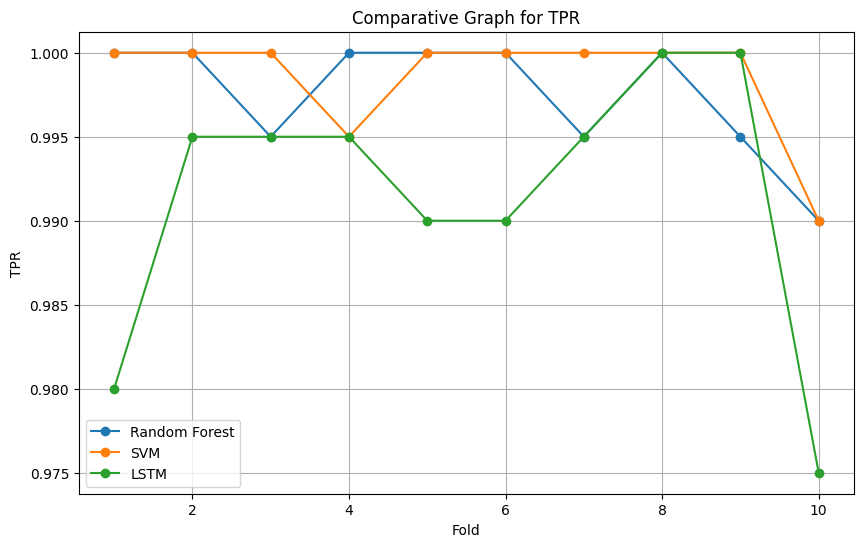

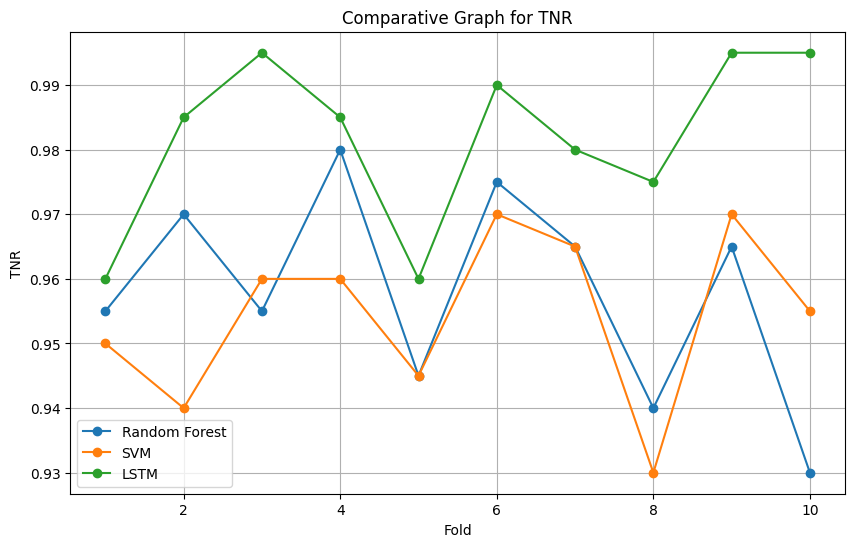

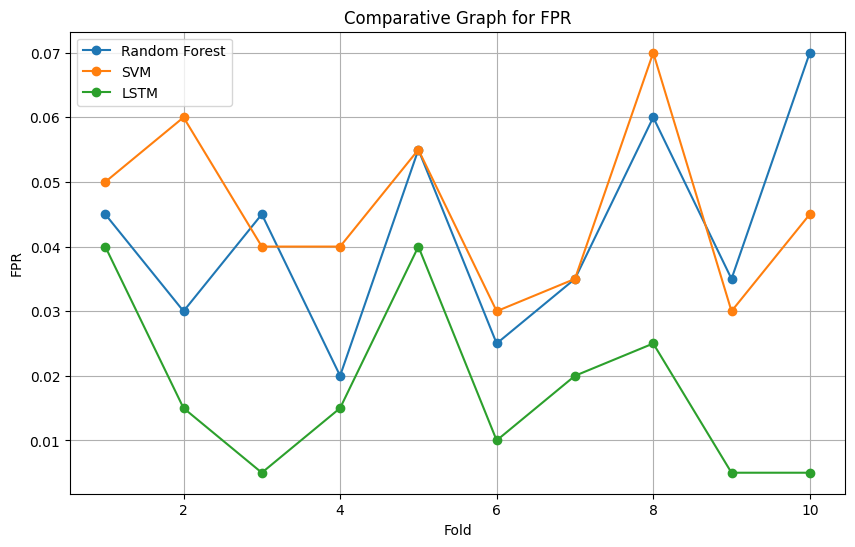

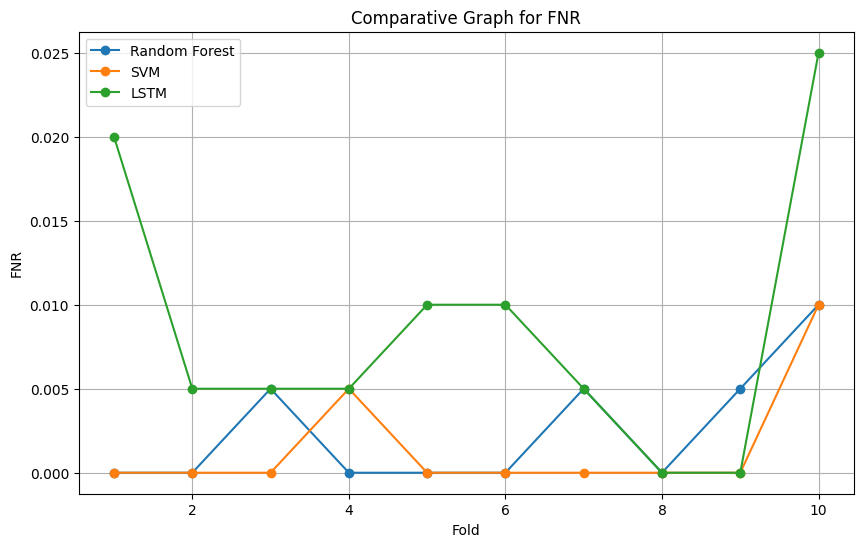

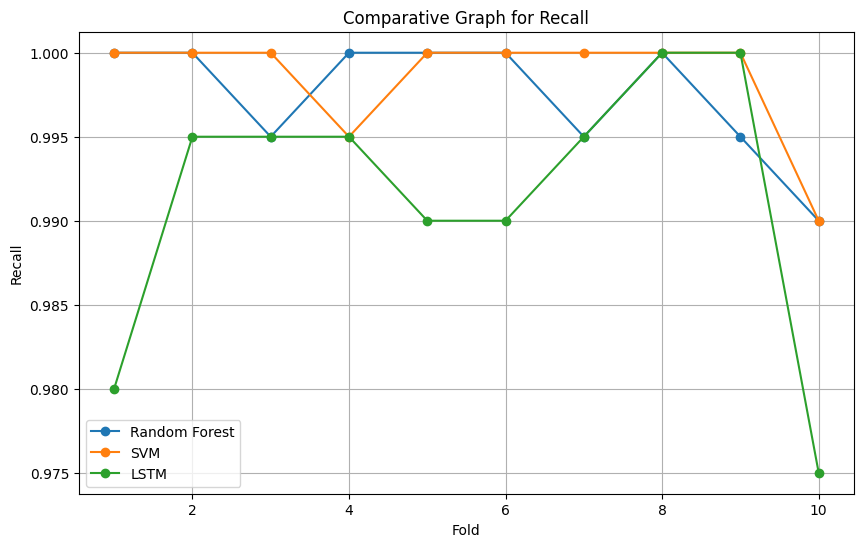

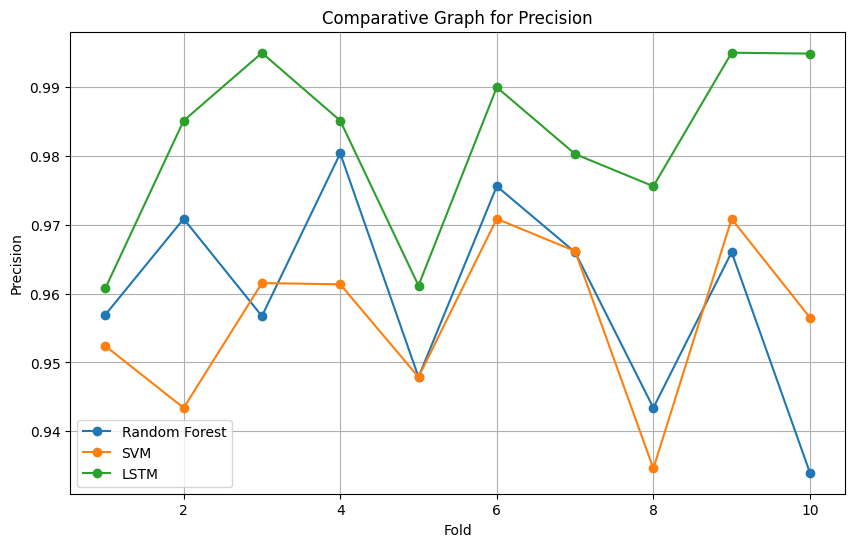

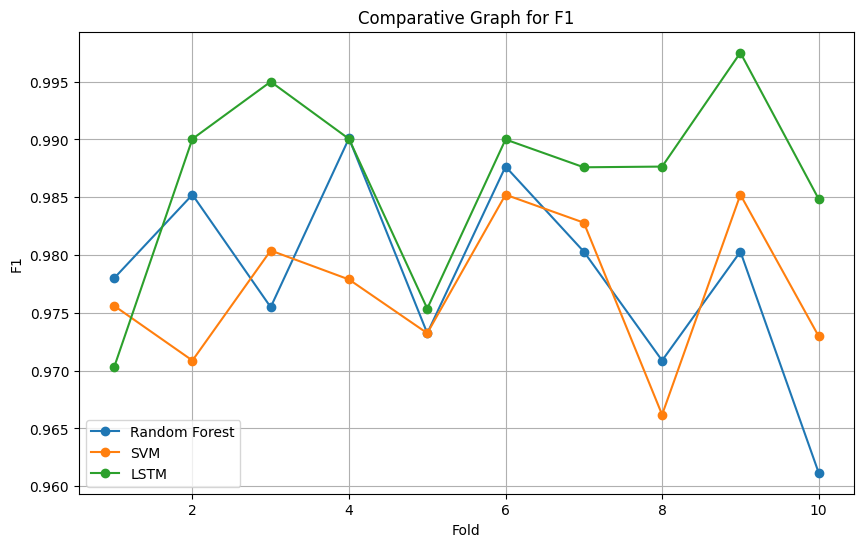

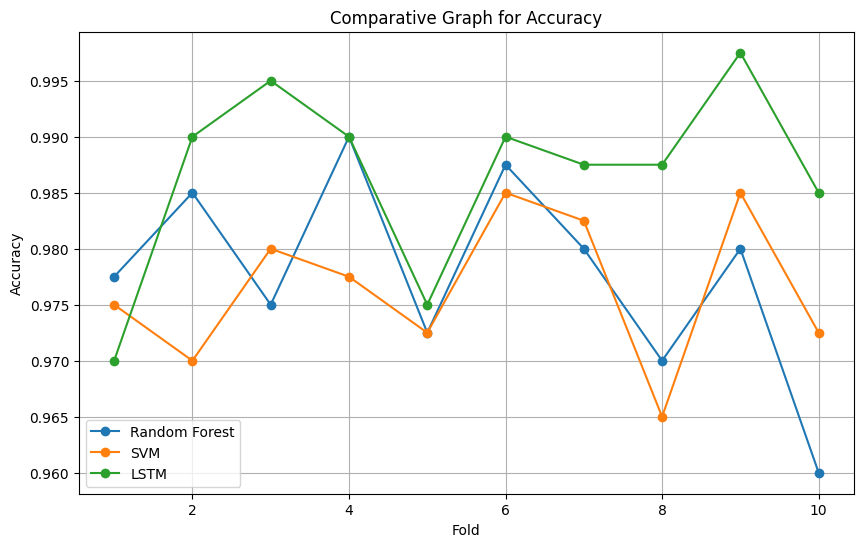

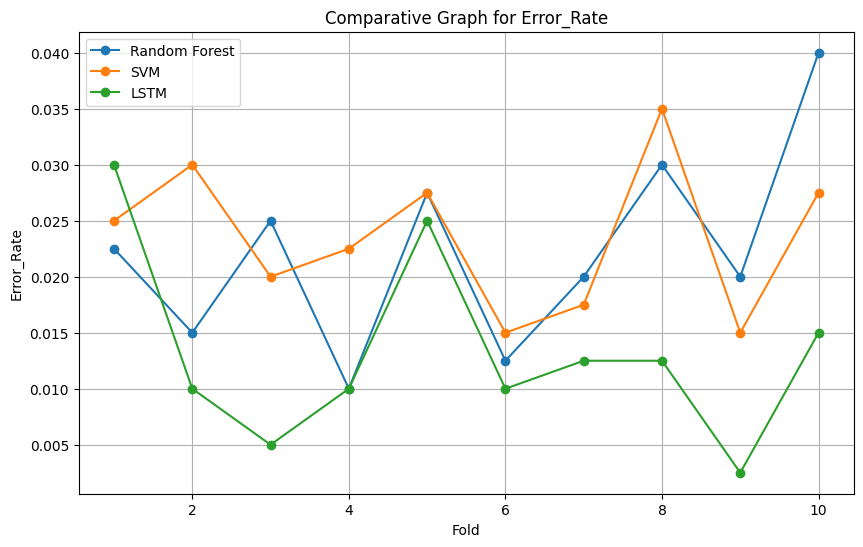

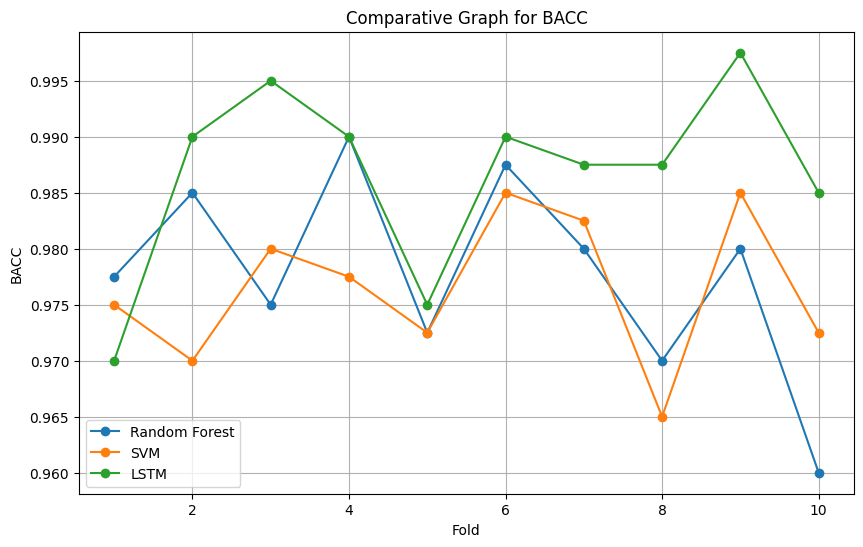

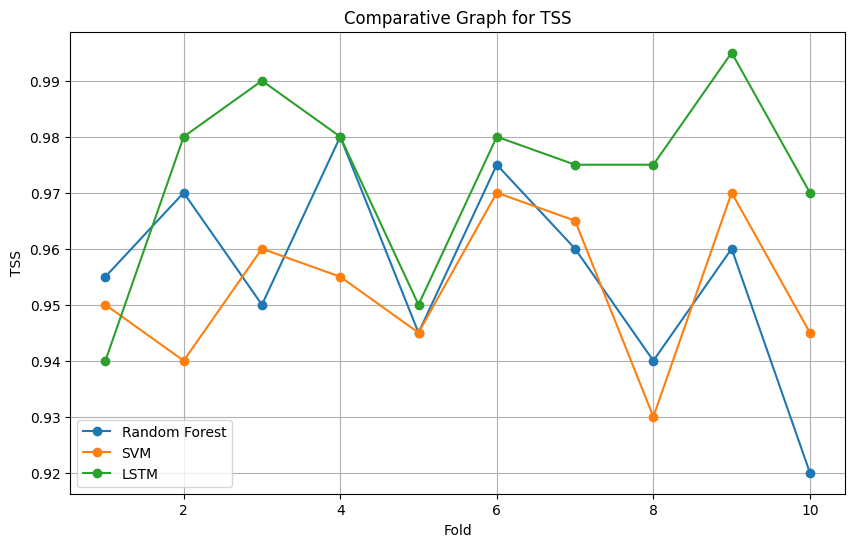

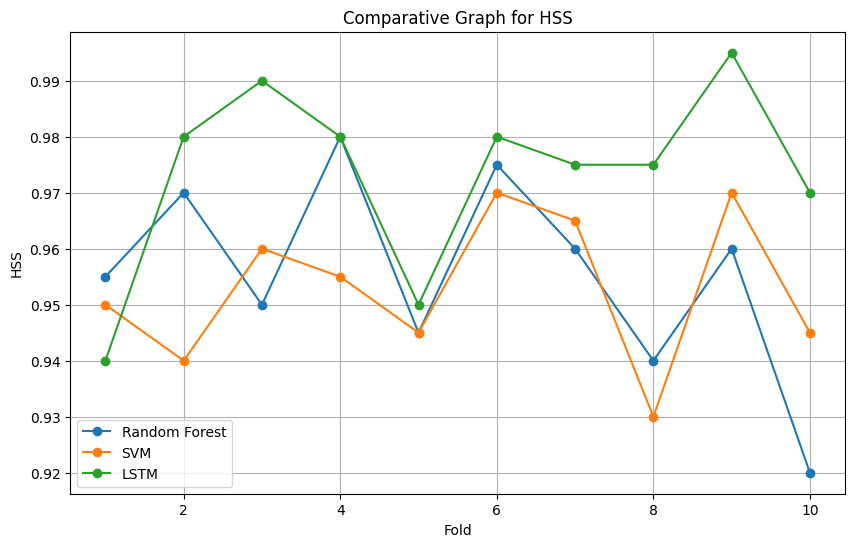

In [30]:
# Plot comparative graph for each metric
for metric_name in metrics_dict[next(iter(metrics_dict))].keys():
    plt.figure(figsize=(10, 6))
    for name, metrics in metrics_dict.items():
        avg_metric = sum(metrics[metric_name]) / len(metrics[metric_name])
        plt.plot(range(1, 11), metrics[metric_name], marker='o', label=name)
    plt.title(f'Comparative Graph for {metric_name}')
    plt.xlabel('Fold')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

In [32]:
for model, metrics in metrics_dict.items():
    df2 = pd.DataFrame(metrics)
    df2['K'] = [i for i in range(1,11)]
    print(f"\nModel: {model}\n")
    print(df2)



Model: Random Forest

     TPR    TNR    FPR    FNR  Recall  Precision        F1  Accuracy  \
0  1.000  0.955  0.045  0.000   1.000   0.956938  0.977995    0.9775   
1  1.000  0.970  0.030  0.000   1.000   0.970874  0.985222    0.9850   
2  0.995  0.955  0.045  0.005   0.995   0.956731  0.975490    0.9750   
3  1.000  0.980  0.020  0.000   1.000   0.980392  0.990099    0.9900   
4  1.000  0.945  0.055  0.000   1.000   0.947867  0.973236    0.9725   
5  1.000  0.975  0.025  0.000   1.000   0.975610  0.987654    0.9875   
6  0.995  0.965  0.035  0.005   0.995   0.966019  0.980296    0.9800   
7  1.000  0.940  0.060  0.000   1.000   0.943396  0.970874    0.9700   
8  0.995  0.965  0.035  0.005   0.995   0.966019  0.980296    0.9800   
9  0.990  0.930  0.070  0.010   0.990   0.933962  0.961165    0.9600   

   Error_Rate    BACC    TSS    HSS   K  
0      0.0225  0.9775  0.955  0.955   1  
1      0.0150  0.9850  0.970  0.970   2  
2      0.0250  0.9750  0.950  0.950   3  
3      0.0100  0

## Conclusion

- Both Random forest and SVM had shown similar results. Their True Positive Rate (TPR), True Negative Rate (TNR), Precision, F1 Score, Accuracy, Error Rate, Balanced Accuracy, True Skill Statistics, and Heidke Skill Score. Their TPR, TNR, Recall, Precision, F1 Score, Accuracy, Balanced Accuracy, True Skill Statistics, and Heidke Skill Score values are consistently high, indicating robust performance.

- False Positive Rate (FPR): Both Random Forest and SVM demonstrate a low FPR, indicates their ability to minimize the misclassification of negative instances as positive.

- LSTM Performance: The LSTM model also performed well, with high TPR, TNR, Recall, Precision, F1 Score, Accuracy, Balanced Accuracy, True Skill Statistics, and Heidke Skill Score values. However, it had shown slightly higher FPR compared to Random Forest and SVM.

All three models—Random Forest, SVM, and LSTM—demonstrated strong performance in terms of classification accuracy and predictive capability. The Random Forest and SVM models exhibit similar performance levels, while the LSTM model also performed well but with a slight higher false positive rate. All three modes perfromed very well on the task.